c:\Users\ivana\.conda\envs\dispanhan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ivana\.conda\envs\dispanhan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ivana\.conda\envs\dispanhan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ivana\.conda\envs\dispanhan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index w

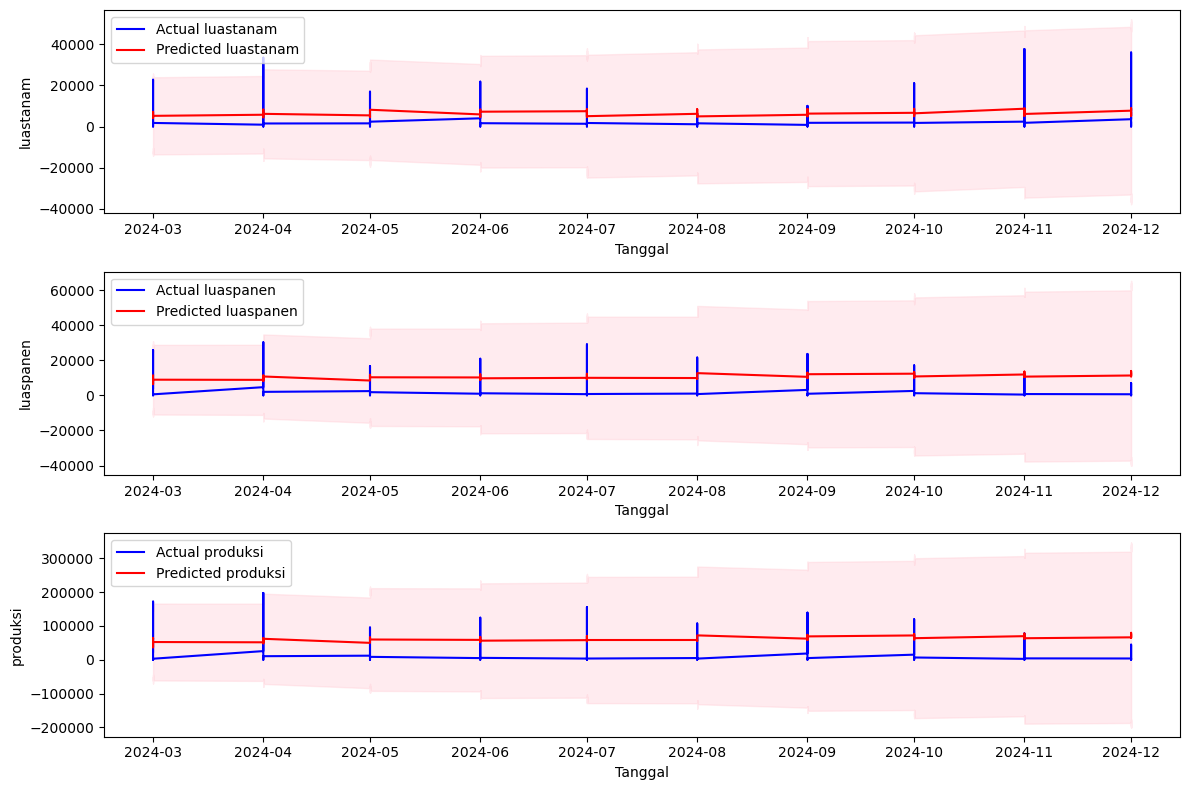

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

# Load dataset dengan delimiter yang benar
df = pd.read_csv("csv/PROGNOSA 2021-2024.csv")

# Mapping bulan ke angka
bulan_mapping = {
    "januari": "01", "februari": "02", "maret": "03", "april": "04",
    "mei": "05", "juni": "06", "juli": "07", "agustus": "08",
    "september": "09", "oktober": "10", "november": "11", "desember": "12"
}

# Konversi bulan ke format numerik dan buat tanggal
df["bulan_num"] = df["bulan"].str.lower().map(bulan_mapping)
df["tanggal"] = pd.to_datetime(df["tahun"].astype(str) + "-" + df["bulan_num"] + "-01")
df = df.sort_values("tanggal")

# Pivot data agar kolom 'tipe' menjadi header baru
df_pivot = df.pivot_table(index=["tanggal", "tanaman", "daerah"], 
                          columns="tipe", values="total").reset_index()

# Pilih tanaman tertentu untuk forecasting (misalnya "padi")
tanaman_pilihan = "padi"
df_filtered = df_pivot[df_pivot["tanaman"].str.lower() == tanaman_pilihan.lower()].copy()

# Pilih fitur yang akan diprediksi
features = ["luastanam", "luaspanen", "produksi"]
df_filtered = df_filtered[["tanggal"] + features].dropna()

# Set index menjadi tanggal agar cocok dengan model ARIMA
df_filtered.set_index("tanggal", inplace=True)

# Train-Test Split (80% Training, 20% Testing)
split = int(len(df_filtered) * 0.8)
train, test = df_filtered[:split], df_filtered[split:]

# Fungsi untuk membuat dan melatih model ARIMA/SARIMA
def train_sarima(train_series, test_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    pred = results.get_forecast(steps=len(test_series))
    pred_ci = pred.conf_int()
    return pred.predicted_mean, pred_ci

# Prediksi untuk setiap fitur
predictions = {}
conf_intervals = {}

for feature in features:
    predictions[feature], conf_intervals[feature] = train_sarima(train[feature], test[feature])

# Visualisasi hasil prediksi
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(3, 1, i+1)
    plt.plot(df_filtered.index[split:], test[feature], label=f"Actual {feature}", color="blue")
    plt.plot(df_filtered.index[split:], predictions[feature], label=f"Predicted {feature}", color="red")
    plt.fill_between(df_filtered.index[split:], conf_intervals[feature].iloc[:, 0], conf_intervals[feature].iloc[:, 1], color="pink", alpha=0.3)
    plt.xlabel("Tanggal")
    plt.ylabel(feature)
    plt.legend()
plt.tight_layout()
plt.show()
